## 025 EVRPE-CEC vs craving-momentum and mood-momentum models (single subject)

Date: 15.Aug.2022

### Purpose

Compare Mixed EVRPE-CEC to momentum models as described in Eldar et al 2015.

### Outline of Plan

1. Copy mixed evrpe-cec models from latest_models_binomial.py
2. Implement momentum models
3. Perform model comparison

### What we did in this notebook

1. Implement the craving momentum (CM) class of models
2. Run the models for targeted subjects
3. Compare model performance to standard mixed EVRPE-CEC class of models

### Overall conclusions
1. For the selected subjects, CM class of models did not outperform the standard EVRPE-CEC models
2. Main takeaway: not worth pursuing momentum models

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import pymc as pm
import aesara.tensor as at
import aesara
from scipy import stats
import time
import arviz as az

from abc import ABC, abstractmethod

from sys import path
import os

root_dir = "/Users/kulkarnik/LocalProjects/SlotsTasks/"
project_dir = f'{root_dir}/online/prolific-food-craving/'
model_functions_path = f'{root_dir}/bayesian_models/slotscraving/'

## Add model_functions to system path
path.append(model_functions_path)

from sepblock_decision.utils import load_data # type: ignore

from joint_models.latest_models_binomial import MixedPrototype

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import arviz as az

## Load data

In [3]:
path_to_summary = f'{project_dir}/rawdata/clean_df_summary.csv'
path_to_longform = f'{project_dir}/rawdata/clean_df_longform.csv'
df_summary, longform = load_data.load_clean_dbs(path_to_summary, path_to_longform)
df_summary = df_summary[
    (df_summary['Money Accuracy']>0.5) & 
    (df_summary['Other Accuracy']>0.5)]
longform = longform[(longform['pid_db'].isin(df_summary['id'])) & (longform['Type']!='practice')]
pid_list = longform['PID'].unique()
print(pid_list.shape)
longform

(36,)


,PID,id,Block,Type,Trial,Cue Time,Action,Action Time,Reward,Reward Time,RT,Spin Speed,Craving Rating,Mood Rating,pid_db
5,61281debe85082cc937dd9ae,6,1,other,1,1.647963e+09,1,1.647963e+09,1,1.647963e+09,0.972,fast,-1.0,-1.0,1
6,61281debe85082cc937dd9ae,7,1,other,2,1.647963e+09,1,1.647963e+09,0,1.647963e+09,0.045,fast,35.0,-1.0,1
7,61281debe85082cc937dd9ae,8,1,other,3,1.647963e+09,0,1.647963e+09,1,1.647963e+09,0.718,slow,-1.0,-1.0,1
8,61281debe85082cc937dd9ae,9,1,other,4,1.647963e+09,0,1.647963e+09,0,1.647963e+09,0.030,slow,-1.0,-1.0,1
9,61281debe85082cc937dd9ae,10,1,other,5,1.647963e+09,0,1.647963e+09,0,1.647963e+09,0.500,fast,34.0,18.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5620,6102d5e6ff92a8dd0cce6b8f,5700,2,other,56,1.648471e+09,1,1.648471e+09,1,1.648471e+09,0.754,slow,-1.0,-1.0,47
5621,6102d5e6ff92a8dd0cce6b8f,5701,2,other,57,1.648471e+09,1,1.648471e+09,1,1.648471e+09,0.637,slow,-1.0,-1.0,47
5622,6102d5e6ff92a8dd0cce6b8f,5702,2,other,58,1.648471e+09,1,1.648471e+09,1,1.648471e+09,0.505,fast,-1.0,-1.0,47
5623,6102d5e6ff92a8dd0cce6b8f,5703,2,other,59,1.648471e+09,1,1.648471e+09,1,1.648471e+09,0.652,fast,-1.0,-1.0,47


## Binomial prototype class imports

In [4]:
## Standard binomial classes
from joint_models.latest_models_binomial import A_RW_0step as A0B
from joint_models.latest_models_binomial import A_RW_1stepSep as A1B
from joint_models.latest_models_binomial import A_RW_2stepSep as A2B

from joint_models.latest_models_binomial import BiasedCEC, HeuCEC, RWCEC

## Batchfit class
from joint_models.latest_models_binomial import BatchFit

## EVRPE-CEC mixed models

In [5]:
class MomentumPrototype(ABC):
    def __init__(self, longform, summary, project_dir, save_path):
        self.name = None        
        self.longform = longform
        self.summary = summary
        self.pid_list = longform['PID'].unique()
        self.traces = {
            'money': {},
            'other': {}
        }
        self.project_dir = project_dir

        num_craving_trials = 20
        num_blocks = 2
        self.craving_inds = None
        self.mean_craving = np.zeros((num_blocks, len(self.pid_list)))
        self.std_craving = np.zeros((num_blocks, len(self.pid_list)))
        self.norm_cravings = np.zeros((num_blocks, len(self.pid_list), num_craving_trials))
        self.cravings = np.zeros((num_blocks, len(self.pid_list), num_craving_trials))
        self._calc_norm_cravings()

        self.save_path = save_path
    
    def _calc_norm_cravings(self):
        for pid_num in range(len(self.pid_list)):
            for b, block in enumerate(['money', 'other']):
                pid = self.pid_list[pid_num]
                cravings = self.longform[(self.longform['PID']==pid)&(self.longform['Type']==block)]['Craving Rating'].values
                craving_inds = np.squeeze(np.argwhere(cravings>-1))
                mask = np.ones(len(craving_inds), dtype=bool)
                mask[12] = False
                craving_inds = craving_inds[mask]
                cravings = cravings[craving_inds]
                self.craving_inds = craving_inds
                self.mean_craving[b, pid_num] = np.mean(cravings)
                self.std_craving[b, pid_num] = np.std(cravings)
                self.norm_cravings[b, pid_num, :] = stats.zscore(cravings)
                self.cravings[b, pid_num, :] = cravings

    @abstractmethod
    def update_Q(self, a, r, Qs, *args):
        pass

    def right_action_probs(self, actions, rewards, beta, cec_weight, *args):
        # Note that the first parameter is always the sample_beta, it is a required argument
        # Note that the second parameter is always the weight assigned to the cue-induced effect
        t_rewards = at.as_tensor_variable(rewards, dtype='int32')
        t_actions = at.as_tensor_variable(actions, dtype='int32')

        # Compute all loop vals
        # 0 - Q[left]
        # 1 - Q[right]
        # 2 - pred_craving
        # 3 - Q[t-1]
        # 4 - Q[t-2]
        # 5 - PE[t-1]
        # 6 - PE[t-2]
        # 7 - momentum
        loopvals =  at.zeros((8,), dtype='float64')
        loopvals, updates = aesara.scan(
            fn=self.update_Q,
            sequences=[t_actions, t_rewards],
            outputs_info=[loopvals],
            non_sequences=[*args])
        t_Qs = loopvals[:, :2]
        # t_pred_craving = pm.math.invlogit(loopvals[:, 2]) ## RETROPROTOTYPE VERSION ##
        t_pred_craving = pm.invlogit(loopvals[:, 2] + cec_weight*t_rewards) ## MIXEDPROTOTYPE VERSION ##

        # Apply the sotfmax transformation
        t_Qs = t_Qs[:-1] * beta
        logp_actions = t_Qs - at.logsumexp(t_Qs, axis=1, keepdims=True)

        # Return the probabilities for the right action, in the original scale
        # Return predicted cravings
        return at.exp(logp_actions[:, 1]),  t_pred_craving
    
    def _load_act_rew_craving(self, pid_num, block, norm=True):
        pid = self.pid_list[pid_num]
        b = 0 if block=='money' else 1
        act = self.longform[(self.longform['PID']==pid) & (self.longform['Type']==block)]['Action'].values
        rew = self.longform[(self.longform['PID']==pid) & (self.longform['Type']==block)]['Reward'].values
        if norm:
            crav = self.norm_cravings[b, pid_num, :]
        else:
            crav = self.cravings[b, pid_num, :]
        return act, rew, crav
    
    @abstractmethod
    def _define_priors(self):
        # Beta must be returned first!
        pass

    def fit(self, pid_num, block):
        pid = self.pid_list[pid_num]
        if self.save_path is not None:
            if not os.path.exists(f'{self.save_path}/{self.name}/'):
                os.makedirs(f'{self.save_path}/{self.name}/')
            filestr = f'{self.save_path}/{self.name}/{block}_{pid}.nc'
            if os.path.exists(filestr):
                print(f'PID: {pid}, Block {block} exists, loading from file...')
                self.traces[block][pid] = az.from_netcdf(filestr)
                return
        act, rew, cravings = self._load_act_rew_craving(pid_num, block, norm=False)
        with pm.Model() as model:
            priors = self._define_priors()
            action_probs, craving_pred = self.right_action_probs(act, rew, *priors)

            like = pm.Bernoulli('like', p=action_probs, observed=act[1:])
            craving_like = pm.Binomial('craving_like', n=50, p=craving_pred[self.craving_inds-1], observed=cravings)
            
            self.traces[block][pid] = pm.sample(step=pm.Metropolis())
            # self.traces[block][pid].extend(pm.sample_prior_predictive())
            pm.sample_posterior_predictive(self.traces[block][pid], extend_inferencedata=True)
            if self.save_path is not None:
                self.traces[block][pid].to_netcdf(filestr)

In [6]:
class CravingMomentum_0step(MomentumPrototype):
    def __init__(self, *args):
        super().__init__(*args)
        self.name = 'CravingMomentum_0step'
        self.type = 'momentum'
        self.retro = 0
        self.decision = 'RW'
        self.craving = 'EVRPE_CEC'

    
    def update_Q(self, a, r, Qs, *args):
        # Note that beta is not present in the args list
        alpha, momentum_alpha, w0, w1, w2, mod = args

        ## Update the Q values - Single update (RW)
        # Calculate trial RPE
        # Qs at indices 0 (left) and 1 (right)
        pe = r - Qs[a]
        momentum_bias = mod*Qs[7]
        Qs = at.set_subtensor(Qs[a], Qs[a] + alpha * (pe+momentum_bias))

        # Update the momentum
        Qs = at.set_subtensor(Qs[7], Qs[7] + momentum_alpha*(pe - Qs[7]))

        ## Calculate predicted craving - TWO STEP (Retro2) - at index 2
        Qs = at.set_subtensor(Qs[2], w0 + w1 * Qs[a] + w2 * pe)

        # Set PE[t-2] at index 6 with PE[t-1] at index 5
        Qs = at.set_subtensor(Qs[6], Qs[5])
        # Set PE[t-1] at index 5 with trial PE
        Qs = at.set_subtensor(Qs[5], pe)
        # Set Qs[t-2] at index 4 with Qs[t-1] at index 3
        Qs = at.set_subtensor(Qs[4], Qs[3])
        # Set Qs[t-1] at index 3 with trial chosen Q
        Qs = at.set_subtensor(Qs[3], Qs[a])
        
        return Qs

    def _define_priors(self):
        beta = pm.HalfNormal('beta', 10)
        untr_alpha = pm.Normal('untr_alpha', mu=0, sigma=1)
        alpha = pm.Deterministic('alpha', pm.math.invlogit(untr_alpha))
        untr_momentum_alpha = pm.Normal('untr_momentum_alpha', mu=0, sigma=1)
        momentum_alpha = pm.Deterministic('momentum_alpha', pm.math.invlogit(untr_momentum_alpha))
        cec_weight = pm.Normal('cec_weight', mu=0, sigma=1)
        weight_zero = pm.Normal('weight_zero', mu=0, sigma=1)
        weight_one = pm.Normal('weight_one', mu=0, sigma=1)
        weight_two = pm.Normal('weight_two', mu=0, sigma=1)
        mod = pm.LogNormal('mod', mu=0, sigma=0.5)
        return beta, cec_weight, alpha, momentum_alpha, weight_zero, weight_one, weight_two, mod


In [7]:
class CravingMomentum_1stepSep(MomentumPrototype):
    def __init__(self, *args):
        super().__init__(*args)
        self.name = 'CravingMomentum_1stepSep'
        self.type = 'momentum'
        self.retro = 1
        self.decision = 'RW'
        self.craving = 'EVRPE_CEC'

    
    def update_Q(self, a, r, Qs, *args):
        # Note that beta is not present in the args list
        alpha, momentum_alpha, w0, w1, w2, w3, w4, mod = args

        ## Update the Q values - Single update (RW)
        # Calculate trial RPE
        # Qs at indices 0 (left) and 1 (right)
        pe = r - Qs[a]
        momentum_bias = mod*Qs[7]
        Qs = at.set_subtensor(Qs[a], Qs[a] + alpha * (pe+momentum_bias))

        # Update the momentum
        Qs = at.set_subtensor(Qs[7], Qs[7] + momentum_alpha*(pe - Qs[7]))

        ## Calculate predicted craving - TWO STEP (Retro2) - at index 2
        Qs = at.set_subtensor(
            Qs[2], 
            w0 + w1*Qs[a] + w2*Qs[3] + w3*pe + w4*Qs[5]
        )

        # Set PE[t-2] at index 6 with PE[t-1] at index 5
        Qs = at.set_subtensor(Qs[6], Qs[5])
        # Set PE[t-1] at index 5 with trial PE
        Qs = at.set_subtensor(Qs[5], pe)
        # Set Qs[t-2] at index 4 with Qs[t-1] at index 3
        Qs = at.set_subtensor(Qs[4], Qs[3])
        # Set Qs[t-1] at index 3 with trial chosen Q
        Qs = at.set_subtensor(Qs[3], Qs[a])
        
        return Qs

    def _define_priors(self):
        beta = pm.HalfNormal('beta', 10)
        untr_alpha = pm.Normal('untr_alpha', mu=0, sigma=1)
        alpha = pm.Deterministic('alpha', pm.math.invlogit(untr_alpha))
        untr_momentum_alpha = pm.Normal('untr_momentum_alpha', mu=0, sigma=1)
        momentum_alpha = pm.Deterministic('momentum_alpha', pm.math.invlogit(untr_momentum_alpha))
        cec_weight = pm.Normal('cec_weight', mu=0, sigma=1)
        weight_zero = pm.Normal('weight_zero', mu=0, sigma=1)
        weight_one = pm.Normal('weight_one', mu=0, sigma=1)
        weight_two = pm.Normal('weight_two', mu=0, sigma=1)
        weight_three = pm.Normal('weight_three', mu=0, sigma=1)
        weight_four = pm.Normal('weight_four', mu=0, sigma=1)
        mod = pm.LogNormal('mod', mu=0, sigma=0.5)
        return beta, cec_weight, alpha, momentum_alpha, weight_zero, weight_one, weight_two, weight_three, weight_four, mod

In [8]:
class CravingMomentum_2stepSep(MomentumPrototype):
    def __init__(self, *args):
        super().__init__(*args)
        self.name = 'CravingMomentum_2stepSep'
        self.type = 'momentum'
        self.retro = 2
        self.decision = 'RW'
        self.craving = 'EVRPE_CEC'

    
    def update_Q(self, a, r, Qs, *args):
        # Note that beta is not present in the args list
        alpha, momentum_alpha, w0, w1, w2, w3, w4, w5, w6, mod = args

        ## Update the Q values - Single update (RW)
        # Calculate trial RPE
        # Qs at indices 0 (left) and 1 (right)
        pe = r - Qs[a]
        momentum_bias = mod*Qs[7]
        Qs = at.set_subtensor(Qs[a], Qs[a] + alpha * (pe+momentum_bias))

        # Update the momentum
        Qs = at.set_subtensor(Qs[7], Qs[7] + momentum_alpha*(pe - Qs[7]))

        ## Calculate predicted craving - TWO STEP (Retro2) - at index 2
        Qs = at.set_subtensor(
            Qs[2], 
            w0 + w1*Qs[a] + w2*Qs[3] + w3*Qs[4] + w4*pe + w5*Qs[5] + w6*Qs[6]
        )

        # Set PE[t-2] at index 6 with PE[t-1] at index 5
        Qs = at.set_subtensor(Qs[6], Qs[5])
        # Set PE[t-1] at index 5 with trial PE
        Qs = at.set_subtensor(Qs[5], pe)
        # Set Qs[t-2] at index 4 with Qs[t-1] at index 3
        Qs = at.set_subtensor(Qs[4], Qs[3])
        # Set Qs[t-1] at index 3 with trial chosen Q
        Qs = at.set_subtensor(Qs[3], Qs[a])
        
        return Qs

    def _define_priors(self):
        beta = pm.HalfNormal('beta', 10)
        untr_alpha = pm.Normal('untr_alpha', mu=0, sigma=1)
        alpha = pm.Deterministic('alpha', pm.math.invlogit(untr_alpha))
        untr_momentum_alpha = pm.Normal('untr_momentum_alpha', mu=0, sigma=1)
        momentum_alpha = pm.Deterministic('momentum_alpha', pm.math.invlogit(untr_momentum_alpha))
        cec_weight = pm.Normal('cec_weight', mu=0, sigma=1)
        weight_zero = pm.Normal('weight_zero', mu=0, sigma=1)
        weight_one = pm.Normal('weight_one', mu=0, sigma=1)
        weight_two = pm.Normal('weight_two', mu=0, sigma=1)
        weight_three = pm.Normal('weight_three', mu=0, sigma=1)
        weight_four = pm.Normal('weight_four', mu=0, sigma=1)
        weight_five = pm.Normal('weight_five', mu=0, sigma=1)
        weight_six = pm.Normal('weight_six', mu=0, sigma=1)
        mod = pm.LogNormal('mod', mu=0, sigma=0.5)
        return beta, cec_weight, alpha, momentum_alpha, weight_zero, weight_one, weight_two, weight_three, weight_four, weight_five, weight_six, mod

## Fit models

In [9]:
save_path = f'{model_functions_path}/exploration/25_trace_output/'
biasedcec = BiasedCEC(longform, df_summary, project_dir, save_path)
heucec = HeuCEC(longform, df_summary, project_dir, save_path)
rwcec = RWCEC(longform, df_summary, project_dir, save_path)
a0b = A0B(longform, df_summary, project_dir, save_path)
a1b = A1B(longform, df_summary, project_dir, save_path)
a2b = A2B(longform, df_summary, project_dir, save_path)
cm0 = CravingMomentum_0step(longform, df_summary, project_dir, save_path)
cm1 = CravingMomentum_1stepSep(longform, df_summary, project_dir, save_path)
cm2 = CravingMomentum_2stepSep(longform, df_summary, project_dir, save_path)

In [30]:
for pid_num in [8, 12]:
    for model in [biasedcec, heucec, rwcec, a0b, a1b, a2b, cm0, cm1, cm2]:
        model.fit(pid_num, 'other')


PID: 612682ec747ac2d5df40f7df, Block other exists, loading from file...
PID: 612682ec747ac2d5df40f7df, Block other exists, loading from file...
PID: 612682ec747ac2d5df40f7df, Block other exists, loading from file...
PID: 612682ec747ac2d5df40f7df, Block other exists, loading from file...
PID: 612682ec747ac2d5df40f7df, Block other exists, loading from file...
PID: 612682ec747ac2d5df40f7df, Block other exists, loading from file...
PID: 612682ec747ac2d5df40f7df, Block other exists, loading from file...
PID: 612682ec747ac2d5df40f7df, Block other exists, loading from file...
PID: 612682ec747ac2d5df40f7df, Block other exists, loading from file...
PID: 5beb92fbe0a3940001543d8c, Block other exists, loading from file...
PID: 5beb92fbe0a3940001543d8c, Block other exists, loading from file...
PID: 5beb92fbe0a3940001543d8c, Block other exists, loading from file...
PID: 5beb92fbe0a3940001543d8c, Block other exists, loading from file...
PID: 5beb92fbe0a3940001543d8c, Block other exists, loading from 

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [untr_alpha]
>Metropolis: [untr_momentum_alpha]
>Metropolis: [cec_weight]
>Metropolis: [weight_zero]
>Metropolis: [weight_one]
>Metropolis: [weight_two]
>Metropolis: [mod]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 56 seconds.


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [untr_alpha]
>Metropolis: [untr_momentum_alpha]
>Metropolis: [cec_weight]
>Metropolis: [weight_zero]
>Metropolis: [weight_one]
>Metropolis: [weight_two]
>Metropolis: [weight_three]
>Metropolis: [weight_four]
>Metropolis: [mod]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 66 seconds.


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [untr_alpha]
>Metropolis: [untr_momentum_alpha]
>Metropolis: [cec_weight]
>Metropolis: [weight_zero]
>Metropolis: [weight_one]
>Metropolis: [weight_two]
>Metropolis: [weight_three]
>Metropolis: [weight_four]
>Metropolis: [weight_five]
>Metropolis: [weight_six]
>Metropolis: [mod]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 76 seconds.


## Output posterior

In [31]:
pid_num = 12

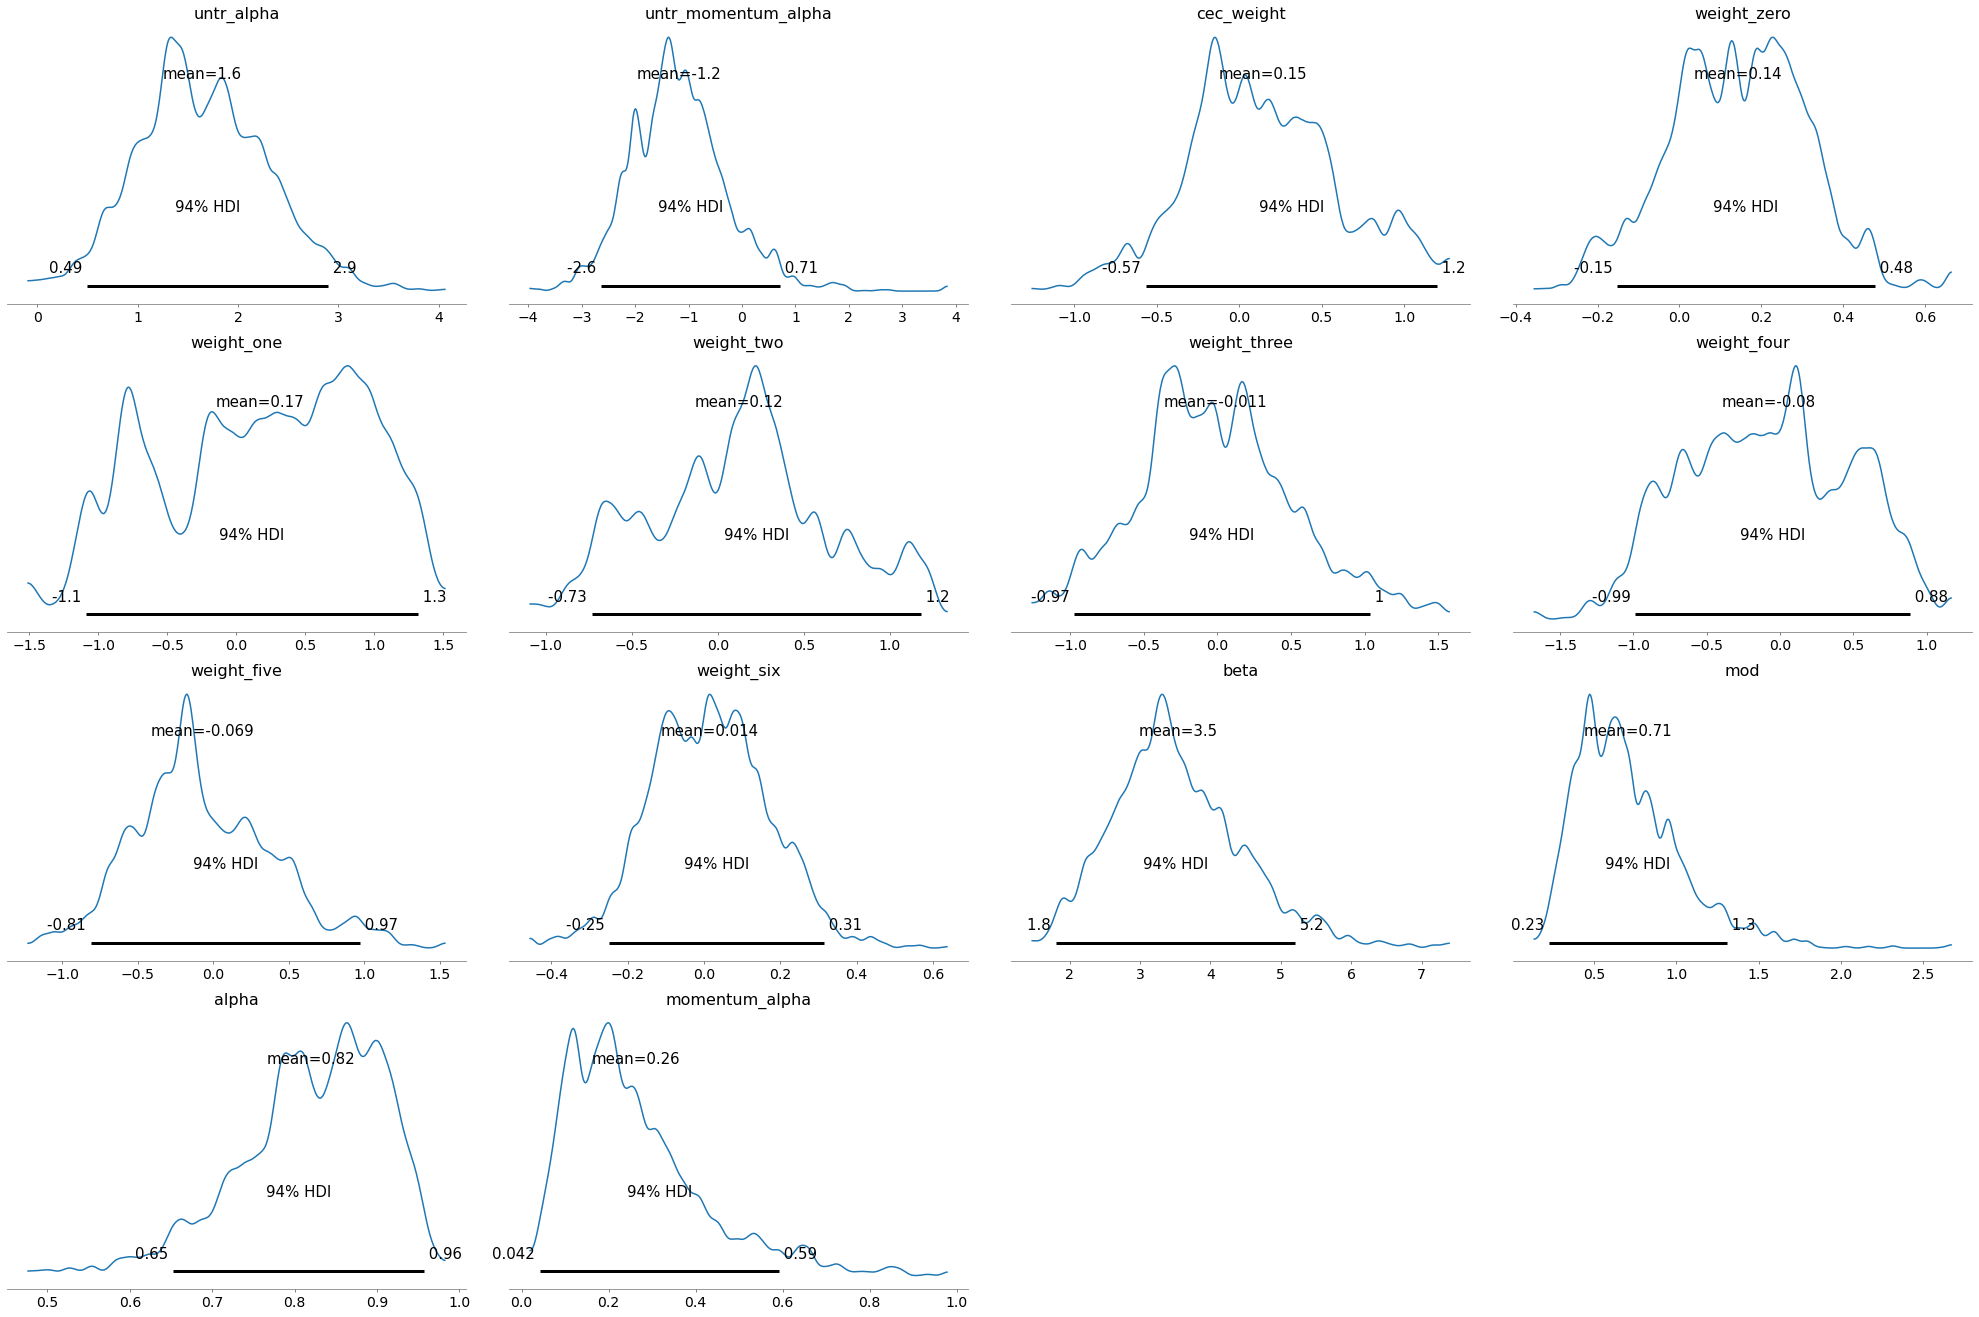

In [32]:
az.plot_posterior(cm2.traces['other'][pid_list[pid_num]])
plt.tight_layout()


## Plotting utils

In [33]:
def plot_ppc_craving(models, pid_num, block):
    b = 0 if block=='money' else 1
    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(15,5), facecolor='w', edgecolor='k')
    model_names = [m.name for m in models]
    samp_model = models[0]
    sns.lineplot(
        x=np.arange(samp_model.cravings[b, pid_num].shape[0]),
        y=samp_model.cravings[b, pid_num],
        label='True craving',
        color='black'
    )
    for i, model in enumerate(models):
        sns.lineplot(
            x=np.arange(len(model.cravings[b, pid_num])),
            y=model.traces[block][model.pid_list[pid_num]].posterior_predictive.craving_like.values[0].mean(axis=0),
            label=f'{model_names[i]}'
        )
    plt.tight_layout()
    plt.close()
    return fig


In [34]:
def plot_ppc_norm_craving(models, pid_num, block):
    b = 0 if block=='money' else 1
    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(15,5), facecolor='w', edgecolor='k')
    model_names = [m.name for m in models]
    samp_model = models[0]
    sns.lineplot(
        x=np.arange(samp_model.norm_cravings[b, pid_num].shape[0]),
        y=samp_model.norm_cravings[b, pid_num],
        label='True craving',
        color='black'
    )
    for i, model in enumerate(models):
        sns.lineplot(
            x=np.arange(len(model.norm_cravings[b, pid_num])),
            y=model.traces[block][model.pid_list[pid_num]].posterior_predictive.craving_like.values[0].mean(axis=0),
            label=f'{model_names[i]}'
        )
    plt.tight_layout()
    plt.close()
    return fig


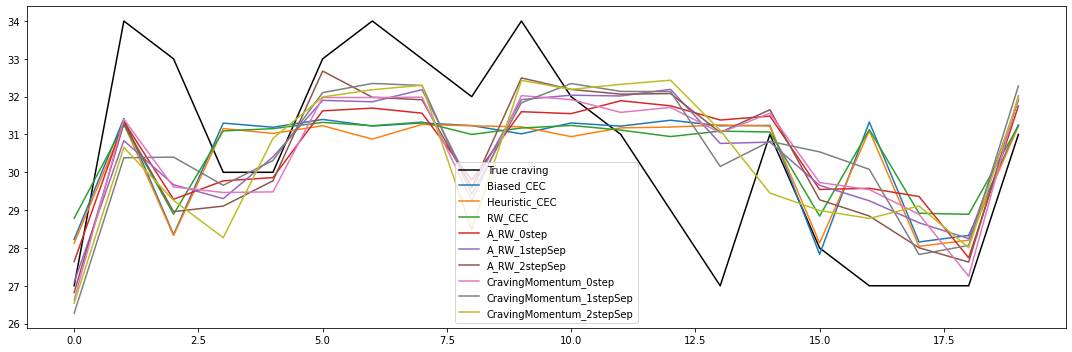

In [35]:
plot_ppc_craving([
    biasedcec, heucec, rwcec,
    a0b, a1b, a2b,
    cm0, cm1, cm2
], pid_num, 'other')

In [36]:
for model in [biasedcec, heucec, rwcec, a0b, a1b, a2b, cm0, cm1, cm2]:
    print(model.name, stats.spearmanr(
        model.traces['other'][pid_list[pid_num]].posterior_predictive.craving_like[2].mean(axis=0).values,
        model.cravings[1, pid_num]
    ))

Biased_CEC SpearmanrResult(correlation=0.339708596819109, pvalue=0.14281315886466875)
Heuristic_CEC SpearmanrResult(correlation=0.008378463150247083, pvalue=0.9720339836266292)
RW_CEC SpearmanrResult(correlation=0.5286048569337706, pvalue=0.016567687351827214)
A_RW_0step SpearmanrResult(correlation=0.5552636033209203, pvalue=0.011037513468984583)
A_RW_1stepSep SpearmanrResult(correlation=0.6398099132915954, pvalue=0.0023811459546122186)
A_RW_2stepSep SpearmanrResult(correlation=0.6019523303031086, pvalue=0.004982132339446432)
CravingMomentum_0step SpearmanrResult(correlation=0.6489500549100468, pvalue=0.0019635299177091776)
CravingMomentum_1stepSep SpearmanrResult(correlation=0.5126096091014806, pvalue=0.020829887227968007)
CravingMomentum_2stepSep SpearmanrResult(correlation=0.6207679515864883, pvalue=0.003492126066878368)


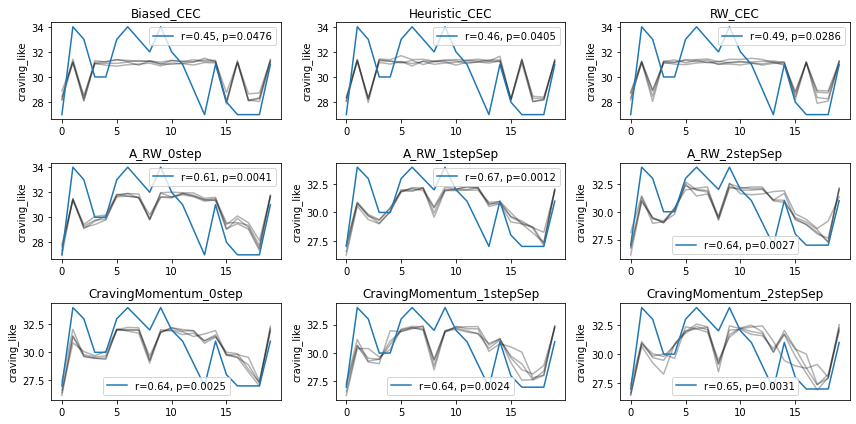

In [37]:
fig, ax = plt.subplots(ncols=3, nrows=3, figsize=(12,6), facecolor='w', edgecolor='k')

for i, model in enumerate([biasedcec, heucec, rwcec, a0b, a1b, a2b, cm0, cm1, cm2]):
    rs = []
    ps = []
    for trace in model.traces['other'][pid_list[pid_num]].posterior_predictive.craving_like:
        r, p = stats.pearsonr(trace.mean(axis=0), model.cravings[1, pid_num])
        rs.append(r)
        ps.append(p)
        sns.lineplot(
            x=np.arange(len(model.cravings[1, pid_num])), 
            y=trace.mean(axis=0), ax=ax[i//3, i%3], 
            color='black', alpha=0.3)
    sns.lineplot(
        x=np.arange(len(model.cravings[1, pid_num])), 
        y=model.cravings[1, pid_num], 
        label=f'r={np.round(np.mean(rs), 2)}, p={np.round(np.mean(ps), 4)}', 
        ax=ax[i//3, i%3])
    ax[i//3, i%3].set_title(model.name)

plt.tight_layout()

## Model comparison of EV and EVRPE

In [38]:
biasedcec.traces['other'][pid_list[pid_num]].log_likelihood.craving_like.values.shape

(4, 1000, 20)

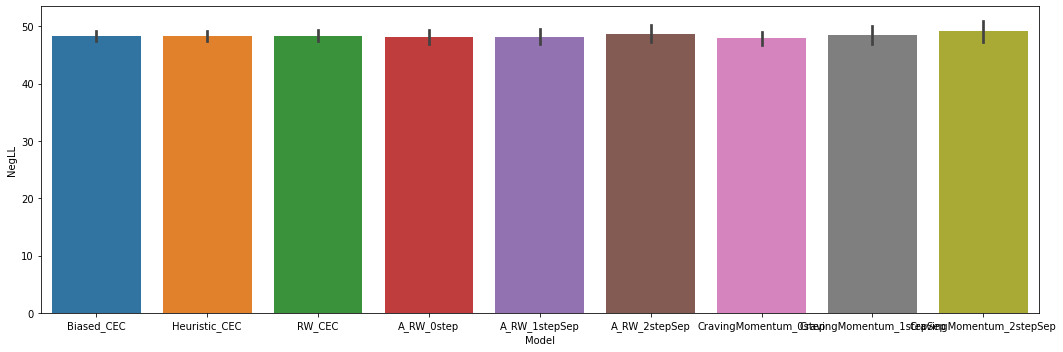

In [39]:
model_names = []
lls = []
for model in [biasedcec, heucec, rwcec, a0b, a1b, a2b, cm0, cm1, cm2]:
    for trace in model.traces['other'][pid_list[pid_num]].log_likelihood.craving_like.values:
        for samp in trace:
            model_names.append(model.name)
            lls.append(-samp.sum())

ll_df = pd.DataFrame({'Model': model_names, 'NegLL': lls})
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(15,5), facecolor='w', edgecolor='k')
sns.barplot(data=ll_df, x='Model', y='NegLL', ci='sd', ax=ax)
# ax.set_ylim(48.5,53)
plt.tight_layout()

In [40]:
ll_df.groupby('Model').agg({'NegLL': ['mean', 'std']})

NegLL          
                               mean       std
Model                                        
A_RW_0step                48.120710  1.210165
A_RW_1stepSep             48.155364  1.294686
A_RW_2stepSep             48.692857  1.500778
Biased_CEC                48.281962  0.841943
CravingMomentum_0step     47.894704  1.188046
CravingMomentum_1stepSep  48.474470  1.488828
CravingMomentum_2stepSep  49.114366  1.802194
Heuristic_CEC             48.280189  0.939308
RW_CEC                    48.370186  0.962214

In [41]:
model_comp = az.compare({
        'Biased': biasedcec.traces['other'][pid_list[pid_num]],
        'Heuristic': heucec.traces['other'][pid_list[pid_num]],
        'RWCEC': rwcec.traces['other'][pid_list[pid_num]],
        'Active0': a0b.traces['other'][pid_list[pid_num]],
        'Active1': a1b.traces['other'][pid_list[pid_num]],
        'Active2': a2b.traces['other'][pid_list[pid_num]],
        'CM0': cm0.traces['other'][pid_list[pid_num]],
        'CM1': cm1.traces['other'][pid_list[pid_num]],
        'CM2': cm2.traces['other'][pid_list[pid_num]]
    },
    ic='loo',
    var_name='craving_like'
)
model_comp

/Users/kulkarnik/miniconda3/envs/pymc_env/lib/python3.10/site-packages/arviz/stats/stats.py:812: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
CM0,0,-48.681726,1.334991,0.000000,6.020087e-01,1.022034,0.000000,False,log
Biased,1,-48.749424,0.849203,0.067698,3.979913e-01,1.344036,0.814566,False,log
Heuristic,2,-48.757231,0.861752,0.075505,0.000000e+00,1.379577,0.825521,False,log
Active0,3,-48.886939,1.314452,0.205213,1.020036e-14,1.134938,0.321156,False,log
RWCEC,4,-48.901218,0.951738,0.219492,1.320187e-15,1.293320,0.776933,False,log
Active1,5,-49.170446,1.696442,0.488720,1.338411e-14,1.041767,0.389328,False,log
CM1,6,-49.838156,2.192055,1.156430,1.068409e-14,1.111687,0.344221,False,log
Active2,7,-50.075966,2.247959,1.394240,8.737786e-15,1.209700,0.420957,False,log
CM2,8,-51.236166,3.211652,2.554440,0.000000e+00,1.159347,0.529170,True,log


<AxesSubplot:xlabel='Log'>

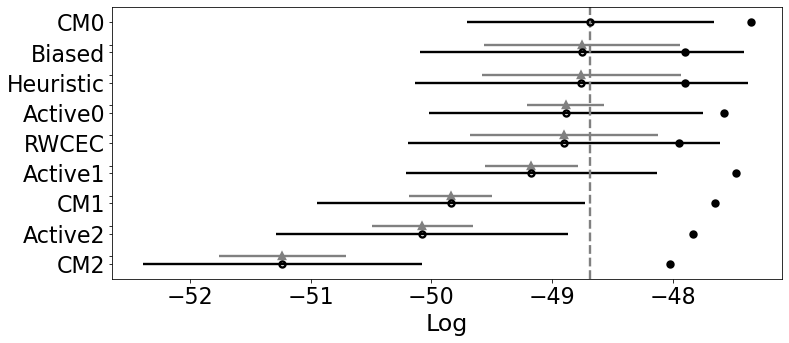

In [42]:
az.plot_compare(model_comp,insample_dev=True, figsize=(12,5))

In [43]:
model_comp = az.compare({
        'Biased': biasedcec.traces['other'][pid_list[pid_num]],
        'Heuristic': heucec.traces['other'][pid_list[pid_num]],
        'RWCEC': rwcec.traces['other'][pid_list[pid_num]],
        'Active0': a0b.traces['other'][pid_list[pid_num]],
        'Active1': a1b.traces['other'][pid_list[pid_num]],
        'Active2': a2b.traces['other'][pid_list[pid_num]],
        'CM0': cm0.traces['other'][pid_list[pid_num]],
        'CM1': cm1.traces['other'][pid_list[pid_num]],
        'CM2': cm2.traces['other'][pid_list[pid_num]]
    },
    ic='loo',
    var_name='like'
)
model_comp

/Users/kulkarnik/miniconda3/envs/pymc_env/lib/python3.10/site-packages/arviz/stats/stats.py:812: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/Users/kulkarnik/miniconda3/envs/pymc_env/lib/python3.10/site-packages/arviz/stats/stats.py:1048: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/Users/kulkarnik/miniconda3/envs/pymc_env/lib/python3.10/site-packages/arviz/stats/stats.py:812: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
Active1,0,-20.612115,2.009266,0.000000,8.161445e-01,5.030006,0.000000,True,log
Active0,1,-20.666001,1.973851,0.053886,0.000000e+00,4.996976,0.167131,True,log
RWCEC,2,-20.721550,1.553014,0.109435,2.076433e-15,4.776967,1.022731,True,log
Active2,3,-20.967683,2.435794,0.355568,0.000000e+00,5.368245,0.453612,True,log
CM2,4,-21.201975,1.628612,0.589860,0.000000e+00,4.421269,2.135311,True,log
CM1,5,-21.263160,1.682979,0.651044,1.205196e-01,4.454836,2.234064,True,log
CM0,6,-21.532402,1.727237,0.920287,5.729634e-17,4.475536,2.282741,True,log
Heuristic,7,-29.384256,0.882004,8.772141,6.333594e-02,4.091662,4.494558,False,log
Biased,8,-40.820218,0.946431,20.208103,0.000000e+00,1.327724,4.974323,False,log


<AxesSubplot:xlabel='Log'>

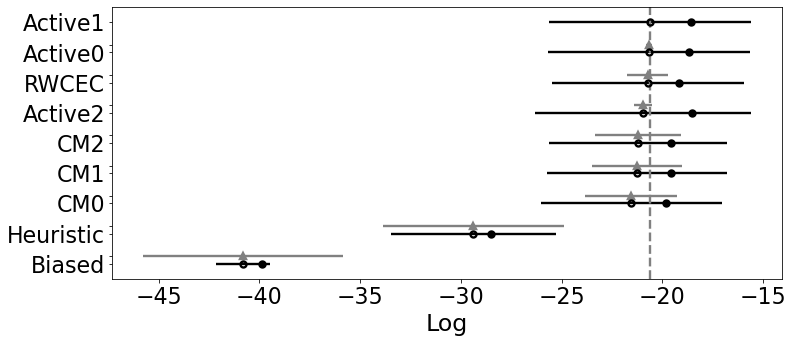

In [44]:
az.plot_compare(model_comp,insample_dev=True, figsize=(12,5))

In [21]:
a2bcec_vars = []
for var in a2bcec.traces['other'][pid_list[pid_num]].posterior.data_vars:
    print(var)
    print(a2bcec.traces['other'][pid_list[pid_num]].posterior[var].values.mean())
    a2bcec_vars.append(a2bcec.traces['other'][pid_list[pid_num]].posterior[var].values.mean())
    # print(a0bcec.traces['other'][pid_list[pid_num]].posterior[var].values.std())
    # print()
    # a0bcec.generate_map_pp()

NameError: name 'a2bcec' is not defined

In [67]:
from scipy.special import expit

In [108]:
act, rew, rate = a2bcec._load_act_rew_craving(pid_num=pid_num, block='other', norm=False)
untr_alpha, cec_weight, weight_zero, weight_one, weight_two, weight_three, weight_four, weight_five, weight_six, beta, mod, alpha = a2bcec_vars
alpha = expit(untr_alpha)

In [109]:
print(alpha)
print(beta)
print(weight_zero, weight_one, weight_two, weight_three, weight_four, weight_five, weight_six)
print(cec_weight)
print(mod)

0.3504141125514121
2.457907088198488
0.19902950025817145 -0.29865166255955533 0.12759861763750954 -0.3170107779101583 -0.1012136379335851 0.07218183204335726 0.06585689623246165
0.3628914433791842
0.7420589387163898


In [125]:
Qs = np.zeros((len(act), 7))
# Compute all loop vals
# 0 - Q[left]
# 1 - Q[right]
# 2 - pred_craving
# 3 - Q[t-1]
# 4 - Q[t-2]
# 5 - PE[t-1]
# 6 - PE[t-2]
for i, (a, r) in enumerate(zip(act, rew)):
    bias = mod*expit(Qs[i-1, 2])
    print(alpha+bias)
    pe = r - Qs[i-1, a]
    Qs[i, a] = Qs[i-1, a] + (alpha+bias) * pe
    Qs[i, 1-a] = Qs[i-1, 1-a]
    Qs[i, 2] = weight_zero + weight_one*Qs[i, a] + weight_one*Qs[i-1,3] + weight_three*Qs[i-1, 4] + weight_four*pe + weight_five*Qs[i-1, 5] + weight_six*Qs[i-1, 6] 

    Qs[i, 6] = Qs[i-1, 5]
    Qs[i, 5] = pe
    Qs[i, 4] = Qs[i-1, 3]
    Qs[i, 3] = Qs[i, a]
    

0.721443581909607
0.6996439374543364
0.6760161033892292
0.6277171630374889
0.6039282003395303
0.5972904717111205
0.5952743484863856
0.5945775934583196
0.641922372023845
0.6123318301558074
0.6846863979145165
0.6370955621884942
0.6429405700390602
0.6201767564642782
0.6030828824761219
0.6456718840233708
0.6656285336130389
0.7102624045316154
0.6829581131276341
0.6725018835694873
0.628909324715442
0.6047354755988935
0.5976256994655382
0.6432581005721454
0.6648253603623125
0.7211047592347187
0.757509397398316
0.7468392564912181
0.743903442800011
0.6953134227605283
0.7304018537956879
0.6699250192050735
0.6546868324645131
0.654261359788231
0.64709280096124
0.6489792537884984
0.5950148402135693
0.6420892224746523
0.6123904439788297
0.6356113968933541
0.6449782088968389
0.6382053799490017
0.6100159507521592
0.6491926218110924
0.6208766363057491
0.6229232073644514
0.5948520276167665
0.5943991763900637
0.644275743730816
0.6877449788023888
0.6581382689373778
0.6425696748177148
0.6266077209756179
0.

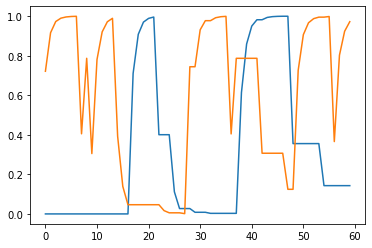

In [123]:
plt.plot(Qs[:, 0])
plt.plot(Qs[:, 1])

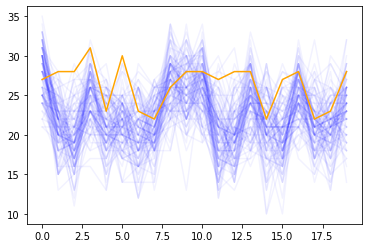

In [127]:
for samp in np.random.binomial(n=50, p=expit(Qs[:, 2] + cec_weight*rew), size=(100, 60)):
    plt.plot(samp[a0bcec.craving_inds-1], color='blue', alpha=0.05)
plt.plot(a0bcec.cravings[1, pid_num, :], color='orange')

In [132]:
expit(cec_weight*rew + Qs[:, 2])

array([0.56100628, 0.52916289, 0.46169771, 0.4272401 , 0.417475  ,
       0.41449575, 0.41346471, 0.39283707, 0.43950815, 0.45046595,
       0.47505482, 0.48331581, 0.45086593, 0.42600021, 0.39788992,
       0.42478354, 0.48493222, 0.53859563, 0.52436306, 0.46340268,
       0.42842319, 0.41796977, 0.3946371 , 0.42370118, 0.4995434 ,
       0.54860236, 0.53422326, 0.53026695, 0.55522519, 0.51207218,
       0.52083286, 0.49977129, 0.40946511, 0.48915488, 0.49179968,
       0.41411182, 0.39306192, 0.43959335, 0.47294944, 0.48618428,
       0.47662712, 0.43613784, 0.40263447, 0.4518748 , 0.45482081,
       0.4138709 , 0.41320057, 0.39600848, 0.4545877 , 0.50456977,
       0.48279305, 0.4601092 , 0.42856865, 0.41841048, 0.39775809,
       0.47011022, 0.4561922 , 0.44042864, 0.47264483, 0.44758158])

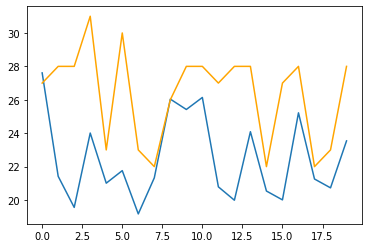

In [119]:
plt.plot(np.random.binomial(n=50, p=expit(Qs[:, 2] + cec_weight*rew), size=(100, 60)).mean(axis=0)[a0bcec.craving_inds-1])
plt.plot(a0bcec.cravings[1, pid_num, :], color='orange')